In [ ]:
# STEP 1 — Robust Dataset Path Setup for Combined Retinal Dataset (macOS)

import os, glob

# ✅ Base dataset directory (UPDATED)
BASE = "/Users/manii/Desktop/RetinaGrader/Retina Vessel Segmentation"

# Helper: get all images recursively
def get_all_images(folder):
    exts = ('*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff', '*.bmp', '*.ppm', '*.gif')
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(folder, '**', ext), recursive=True))
    return sorted(files)

# ✅ Directories (match your folder names exactly)
TRAIN_IMG_DIR = os.path.join(BASE, "Training", "images")
TRAIN_MSK_DIR = os.path.join(BASE, "Training", "masks")

TEST_IMG_DIR  = os.path.join(BASE, "Test", "images")
TEST_MSK_DIR  = os.path.join(BASE, "Test", "masks")

UNLABELED_DIR = os.path.join(BASE, "Test Unlabeled", "images")

# Collect files
train_imgs = get_all_images(TRAIN_IMG_DIR)
train_msks = get_all_images(TRAIN_MSK_DIR)
test_imgs  = get_all_images(TEST_IMG_DIR)
test_msks  = get_all_images(TEST_MSK_DIR)
unlabeled  = get_all_images(UNLABELED_DIR)

# Print results
print(f"📁 Training → {len(train_imgs)} images, {len(train_msks)} masks")
print(f"📁 Test     → {len(test_imgs)} images, {len(test_msks)} masks")
print(f"📁 Unlabeled→ {len(unlabeled)} images")

# Sanity check
if len(train_imgs) == len(train_msks) and len(test_imgs) == len(test_msks):
    print("✅ Dataset structure verified successfully.")
else:
    print("⚠️ Warning: mismatch between image/mask counts.")


📁 Training → 126 images, 126 masks
📁 Test     → 35 images, 35 masks
📁 Unlabeled→ 417 images
✅ Dataset structure verified successfully.


In [2]:
imgs, masks = next(iter(train_loader))
print("IMG :", imgs.shape)
print("MASK:", masks.shape)


NameError: name 'train_loader' is not defined

In [3]:
# ============================================================
# STEP 2 — Enhanced Preprocessing + DataLoader (512×512, Vessel Boost)
# ============================================================

import os, cv2, numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from sklearn.model_selection import train_test_split

IMG_SIZE = 512
np.random.seed(42)

# ---------- 1️⃣  Image + Mask preprocessing ----------
def pad_to_square(img, pad_value=0):
    h, w = img.shape[:2]
    if h == w:
        return img
    diff = abs(h - w)
    pad1, pad2 = diff // 2, diff - diff // 2
    if h < w:
        return cv2.copyMakeBorder(img, pad1, pad2, 0, 0, cv2.BORDER_CONSTANT, value=pad_value)
    else:
        return cv2.copyMakeBorder(img, 0, 0, pad1, pad2, cv2.BORDER_CONSTANT, value=pad_value)

def preprocess_image(img_path):
    """Green-channel extraction + CLAHE + gamma correction + normalization"""
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(img_path)

    # Focus on green channel (best contrast for retinal vessels)
    green = img[:, :, 1]

    # CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eq = clahe.apply(green)

    # Gamma correction to brighten fine vessels
    eq = np.power(eq / 255.0, 0.8) * 255.0

    # Pad and resize to 512×512
    eq = pad_to_square(eq)
    eq = cv2.resize(eq, (IMG_SIZE, IMG_SIZE))
    eq = eq.astype(np.float32) / 255.0
    return np.expand_dims(eq, -1)  # (H,W,1)

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(mask_path)
    mask = pad_to_square(mask)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    return np.expand_dims(mask, -1)

# ---------- 2️⃣  Data augmentation ----------
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ElasticTransform(p=0.3, alpha=50, sigma=5, alpha_affine=10),
    A.RandomBrightnessContrast(p=0.3),
    ToTensorV2()
])

val_transform = A.Compose([ToTensorV2()])

# ---------- 3️⃣  Dataset class ----------
class RetinalDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = preprocess_image(self.image_paths[idx])   # (H, W, 1)
        mask = preprocess_mask(self.mask_paths[idx])    # (H, W, 1)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]           # (1, H, W)  ✔
            mask = aug["mask"]           # (H, W, 1)  ❌
            mask = mask.permute(2, 0, 1) # (1, H, W)  ✔
        else:
            img = torch.tensor(img).permute(2, 0, 1)
            mask = torch.tensor(mask).permute(2, 0, 1)

        return img.float(), mask.float()




# ---------- 4️⃣  Split train/val/test ----------
train_imgs_split, val_imgs_split, train_msks_split, val_msks_split = train_test_split(
    train_imgs, train_msks, test_size=0.18, random_state=42
)

train_ds = RetinalDataset(train_imgs_split, train_msks_split, transform=augment)
val_ds   = RetinalDataset(val_imgs_split, val_msks_split, transform=val_transform)
test_ds  = RetinalDataset(test_imgs, test_msks, transform=val_transform)

train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True   # ⭐ REQUIRED
)

val_loader = DataLoader(
    val_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=2,
    shuffle=False,
    num_workers=0
)

print(f"✅ Enhanced preprocessing complete (512×512 + contrast + augmentation)")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)} images")



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Enhanced preprocessing complete (512×512 + contrast + augmentation)
Train: 103 | Val: 23 | Test: 35 images


/var/folders/l4/x341hg057g3gxx35rnt015pr0000gn/T/ipykernel_2689/1514725684.py:63: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=50, sigma=5, alpha_affine=10),


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- ConvBlock ----
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

# ---- Multi-Scale Attention ----
class MSA(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 1)
        self.conv3 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv5 = nn.Conv2d(ch, ch, 5, padding=2)
        self.fc1   = nn.Conv2d(ch, ch//8, 1)
        self.fc2   = nn.Conv2d(ch//8, ch, 1)
    def forward(self, x):
        s = self.conv1(x) + self.conv3(x) + self.conv5(x)
        w = F.adaptive_avg_pool2d(s, 1)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(w))))
        return s * w

# ---- Cross-Layer Fusion ----
class CLFM(nn.Module):
    def __init__(self, in_ch1, in_ch2, out_ch):
        super().__init__()
        self.reduce1 = nn.Conv2d(in_ch1, out_ch, 1)
        self.reduce2 = nn.Conv2d(in_ch2, out_ch, 1)
    def forward(self, f1, f2):
        if f1.shape[-1] != f2.shape[-1]:
            f2 = F.interpolate(f2, size=f1.shape[-2:], mode="bilinear", align_corners=False)
        return self.reduce1(f1) * self.reduce2(f2)

# ---- Dual-Input Fusion ----
class DIFM(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.fc1 = nn.Conv2d(ch, ch//8, 1)
        self.fc2 = nn.Conv2d(ch//8, ch, 1)
    def weigh(self, x):
        w = F.adaptive_avg_pool2d(x, 1)
        w = torch.sigmoid(self.fc2(F.relu(self.fc1(w))))
        return x * w
    def forward(self, e, d):
        return self.weigh(e) + self.weigh(d)

# ---- MSF-Net (verified channel flow) ----
class MSFNet(nn.Module):
    def __init__(self, in_ch=1, base=32):
        super().__init__()
        # Encoder
        self.e1 = ConvBlock(in_ch, base)          # 32
        self.e2 = ConvBlock(base, base*2)         # 64
        self.e3 = ConvBlock(base*2, base*4)       # 128
        self.e4 = ConvBlock(base*4, base*8)       # 256
        self.b  = ConvBlock(base*8, base*16)      # 512
        self.msa = MSA(base*16)

        # Decoder (each step doubles spatial size, halves channels)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, 2)
        self.clf4 = CLFM(base*8, base*4, base*8)
        self.d4  = ConvBlock(base*8 + base*8, base*8)    # (256+256 → 256)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, 2)
        self.d3  = ConvBlock(base*4 + base*2, base*4)    # (128+64 → 128)

        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.d2  = ConvBlock(base*2 + base, base*2)      # (64+32 → 64)

        self.up1 = nn.ConvTranspose2d(base*2, base, 2, 2)
        self.d1  = ConvBlock(base + base, base)          # (32+32 → 32)

        self.dif = DIFM(base)
        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        # Encoder
        c1 = self.e1(x); p1 = F.max_pool2d(c1, 2)
        c2 = self.e2(p1); p2 = F.max_pool2d(c2, 2)
        c3 = self.e3(p2); p3 = F.max_pool2d(c3, 2)
        c4 = self.e4(p3); p4 = F.max_pool2d(c4, 2)
        b  = self.msa(self.b(p4))

        # Decoder
        u4 = self.up4(b)
        f4 = self.clf4(c4, c3)
        d4 = self.d4(torch.cat([u4, f4], dim=1))

        u3 = self.up3(d4)
        c2_r = F.interpolate(c2, size=u3.shape[-2:], mode="bilinear", align_corners=False)
        d3 = self.d3(torch.cat([u3, c2_r], dim=1))

        u2 = self.up2(d3)
        c1_r = F.interpolate(c1, size=u2.shape[-2:], mode="bilinear", align_corners=False)
        d2 = self.d2(torch.cat([u2, c1_r], dim=1))

        u1 = self.up1(d2)
        d1 = self.d1(torch.cat([u1, c1], dim=1))
        d1 = self.dif(c1, d1)

        return self.out(d1)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = MSFNet(in_ch=1, base=32).to(DEVICE)
xb, yb = next(iter(train_loader))
xb = xb.to(DEVICE).float()
with torch.no_grad():
    logits = model(xb)
print("✅ sanity:", tuple(xb.shape), "→", tuple(logits.shape))


✅ sanity: (2, 1, 512, 512) → (2, 1, 512, 512)


In [36]:
# ============================================================
# STEP 4 — MSF-Net FINAL TRAINING (ONE-CELL, SHAPE-SAFE)
# ============================================================

import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Training device:", DEVICE)

# ------------------ Loss Functions ------------------
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = 1 - (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def bce_dice_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)
    return 0.5 * bce + 0.5 * dice

# ------------------ Metrics ------------------
def compute_metrics(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + 1e-6) / (union + 1e-6)
    iou  = (intersection + 1e-6) / ((pred + target - pred*target).sum() + 1e-6)
    acc  = (pred == target).float().mean()
    return dice.item(), iou.item(), acc.item()

# ------------------ Optimizer & Scheduler ------------------
optimizer = optim.Adam(model.parameters(), lr=3e-4)  # 🔥 best for vessels
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

# ------------------ Training Loop ------------------
EPOCHS = 150   # explained below 👇

for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False):
        imgs  = imgs.to(DEVICE)    # [B,1,H,W]
        masks = masks.to(DEVICE)   # [B,1,H,W]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = bce_dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # ---- Validate ----
    model.eval()
    val_loss = val_dice = val_iou = val_acc = 0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False):
            imgs  = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = model(imgs)
            loss = bce_dice_loss(outputs, masks)
            dice, iou, acc = compute_metrics(outputs, masks)

            val_loss += loss.item()
            val_dice += dice
            val_iou  += iou
            val_acc  += acc

    n = len(val_loader)
    val_loss /= n
    val_dice /= n
    val_iou  /= n
    val_acc  /= n

    scheduler.step()

    print(
        f"Epoch {epoch:03d} | "
        f"TrainLoss {train_loss:.4f} | "
        f"ValLoss {val_loss:.4f} | "
        f"Dice {val_dice:.4f} | "
        f"IoU {val_iou:.4f} | "
        f"Acc {val_acc:.4f}"
    )

print("✅ MSF-Net training completed successfully")


Training device: cpu


Epoch 001 | TrainLoss 0.7123 | ValLoss 0.6592 | Dice 0.5158 | IoU 0.3521 | Acc 0.9392


Epoch 002 | TrainLoss 0.6179 | ValLoss 0.5852 | Dice 0.5946 | IoU 0.4287 | Acc 0.9276


Epoch 003 | TrainLoss 0.5626 | ValLoss 0.5449 | Dice 0.6380 | IoU 0.4748 | Acc 0.9431


Epoch 004 | TrainLoss 0.5093 | ValLoss 0.4900 | Dice 0.6742 | IoU 0.5145 | Acc 0.9506


Epoch 005 | TrainLoss 0.4537 | ValLoss 0.4291 | Dice 0.7048 | IoU 0.5495 | Acc 0.9616


Epoch 006 | TrainLoss 0.3986 | ValLoss 0.3867 | Dice 0.7024 | IoU 0.5469 | Acc 0.9575


Epoch 007 | TrainLoss 0.3541 | ValLoss 0.3288 | Dice 0.7147 | IoU 0.5606 | Acc 0.9644


Epoch 008 | TrainLoss 0.3140 | ValLoss 0.2974 | Dice 0.7248 | IoU 0.5737 | Acc 0.9639


Epoch 009 | TrainLoss 0.2853 | ValLoss 0.2729 | Dice 0.7227 | IoU 0.5705 | Acc 0.9653


Epoch 010 | TrainLoss 0.2658 | ValLoss 0.2501 | Dice 0.7266 | IoU 0.5766 | Acc 0.9658


Epoch 011 | TrainLoss 0.2515 | ValLoss 0.2421 | Dice 0.7304 | IoU 0.5817 | Acc 0.9674


Epoch 012 | TrainLoss 0.2399 | ValLoss 0.2362 | Dice 0.7294 | IoU 0.5792 | Acc 0.9672


Epoch 013 | TrainLoss 0.2351 | ValLoss 0.2331 | Dice 0.7221 | IoU 0.5703 | Acc 0.9673


Epoch 014 | TrainLoss 0.2329 | ValLoss 0.2128 | Dice 0.7470 | IoU 0.6013 | Acc 0.9683


Epoch 015 | TrainLoss 0.2240 | ValLoss 0.2117 | Dice 0.7450 | IoU 0.5984 | Acc 0.9690


Epoch 016 | TrainLoss 0.2195 | ValLoss 0.2126 | Dice 0.7411 | IoU 0.5937 | Acc 0.9646


Epoch 017 | TrainLoss 0.2224 | ValLoss 0.2073 | Dice 0.7499 | IoU 0.6047 | Acc 0.9679


Epoch 018 | TrainLoss 0.2165 | ValLoss 0.2053 | Dice 0.7469 | IoU 0.6015 | Acc 0.9686


Epoch 019 | TrainLoss 0.2153 | ValLoss 0.2088 | Dice 0.7415 | IoU 0.5942 | Acc 0.9647


Epoch 020 | TrainLoss 0.2159 | ValLoss 0.2050 | Dice 0.7433 | IoU 0.5968 | Acc 0.9696


Epoch 021 | TrainLoss 0.2149 | ValLoss 0.2102 | Dice 0.7374 | IoU 0.5895 | Acc 0.9688


Epoch 022 | TrainLoss 0.2131 | ValLoss 0.2004 | Dice 0.7511 | IoU 0.6064 | Acc 0.9681


Epoch 023 | TrainLoss 0.2113 | ValLoss 0.1954 | Dice 0.7597 | IoU 0.6178 | Acc 0.9688


Epoch 024 | TrainLoss 0.2092 | ValLoss 0.1966 | Dice 0.7536 | IoU 0.6100 | Acc 0.9702


Epoch 025 | TrainLoss 0.2103 | ValLoss 0.1955 | Dice 0.7550 | IoU 0.6121 | Acc 0.9702


Epoch 026 | TrainLoss 0.2075 | ValLoss 0.1954 | Dice 0.7566 | IoU 0.6133 | Acc 0.9692


Epoch 027 | TrainLoss 0.2096 | ValLoss 0.1933 | Dice 0.7573 | IoU 0.6153 | Acc 0.9704


Epoch 028 | TrainLoss 0.2053 | ValLoss 0.1875 | Dice 0.7673 | IoU 0.6280 | Acc 0.9707


Epoch 029 | TrainLoss 0.2087 | ValLoss 0.1952 | Dice 0.7615 | IoU 0.6204 | Acc 0.9691


Epoch 030 | TrainLoss 0.2041 | ValLoss 0.1921 | Dice 0.7593 | IoU 0.6182 | Acc 0.9713


Epoch 031 | TrainLoss 0.2042 | ValLoss 0.1833 | Dice 0.7716 | IoU 0.6333 | Acc 0.9710


Epoch 032 | TrainLoss 0.1960 | ValLoss 0.1868 | Dice 0.7663 | IoU 0.6264 | Acc 0.9705


Epoch 033 | TrainLoss 0.2034 | ValLoss 0.1953 | Dice 0.7560 | IoU 0.6124 | Acc 0.9687


Epoch 034 | TrainLoss 0.2053 | ValLoss 0.1882 | Dice 0.7651 | IoU 0.6252 | Acc 0.9713


Epoch 035 | TrainLoss 0.2040 | ValLoss 0.1860 | Dice 0.7676 | IoU 0.6281 | Acc 0.9714


Epoch 036 | TrainLoss 0.2038 | ValLoss 0.1872 | Dice 0.7665 | IoU 0.6261 | Acc 0.9693


Epoch 037 | TrainLoss 0.2032 | ValLoss 0.1853 | Dice 0.7709 | IoU 0.6324 | Acc 0.9706


Epoch 038 | TrainLoss 0.2045 | ValLoss 0.1860 | Dice 0.7682 | IoU 0.6289 | Acc 0.9710


Epoch 039 | TrainLoss 0.2039 | ValLoss 0.1821 | Dice 0.7736 | IoU 0.6361 | Acc 0.9710


Epoch 040 | TrainLoss 0.2039 | ValLoss 0.1843 | Dice 0.7712 | IoU 0.6326 | Acc 0.9708


Epoch 041 | TrainLoss 0.2013 | ValLoss 0.1788 | Dice 0.7781 | IoU 0.6419 | Acc 0.9718


Epoch 042 | TrainLoss 0.2010 | ValLoss 0.1834 | Dice 0.7709 | IoU 0.6326 | Acc 0.9717


Epoch 043 | TrainLoss 0.1997 | ValLoss 0.1864 | Dice 0.7645 | IoU 0.6232 | Acc 0.9715


Epoch 044 | TrainLoss 0.2006 | ValLoss 0.1812 | Dice 0.7735 | IoU 0.6355 | Acc 0.9712


Epoch 045 | TrainLoss 0.1991 | ValLoss 0.1899 | Dice 0.7626 | IoU 0.6213 | Acc 0.9677


Epoch 046 | TrainLoss 0.1990 | ValLoss 0.1828 | Dice 0.7688 | IoU 0.6308 | Acc 0.9723


Epoch 047 | TrainLoss 0.1988 | ValLoss 0.1821 | Dice 0.7717 | IoU 0.6333 | Acc 0.9719


Epoch 048 | TrainLoss 0.1983 | ValLoss 0.1840 | Dice 0.7694 | IoU 0.6299 | Acc 0.9714


Epoch 049 | TrainLoss 0.1988 | ValLoss 0.2009 | Dice 0.7458 | IoU 0.5994 | Acc 0.9696


Epoch 050 | TrainLoss 0.1998 | ValLoss 0.1819 | Dice 0.7731 | IoU 0.6353 | Acc 0.9705


Epoch 051 | TrainLoss 0.1981 | ValLoss 0.1756 | Dice 0.7812 | IoU 0.6462 | Acc 0.9721


Epoch 052 | TrainLoss 0.1975 | ValLoss 0.1788 | Dice 0.7761 | IoU 0.6395 | Acc 0.9719


Epoch 053 | TrainLoss 0.1975 | ValLoss 0.1781 | Dice 0.7746 | IoU 0.6379 | Acc 0.9729


Epoch 054 | TrainLoss 0.1961 | ValLoss 0.1774 | Dice 0.7763 | IoU 0.6400 | Acc 0.9725


Epoch 055 | TrainLoss 0.1971 | ValLoss 0.1735 | Dice 0.7849 | IoU 0.6510 | Acc 0.9726


Epoch 056 | TrainLoss 0.1949 | ValLoss 0.1750 | Dice 0.7805 | IoU 0.6450 | Acc 0.9724


Epoch 057 | TrainLoss 0.1939 | ValLoss 0.1781 | Dice 0.7768 | IoU 0.6401 | Acc 0.9723


Epoch 058 | TrainLoss 0.1966 | ValLoss 0.1764 | Dice 0.7809 | IoU 0.6457 | Acc 0.9716


Epoch 059 | TrainLoss 0.1931 | ValLoss 0.1747 | Dice 0.7816 | IoU 0.6469 | Acc 0.9723


Epoch 060 | TrainLoss 0.1962 | ValLoss 0.1757 | Dice 0.7818 | IoU 0.6478 | Acc 0.9728


Epoch 061 | TrainLoss 0.1946 | ValLoss 0.1743 | Dice 0.7810 | IoU 0.6464 | Acc 0.9736


Epoch 062 | TrainLoss 0.1957 | ValLoss 0.1796 | Dice 0.7748 | IoU 0.6378 | Acc 0.9719


Epoch 063 | TrainLoss 0.1946 | ValLoss 0.1736 | Dice 0.7839 | IoU 0.6497 | Acc 0.9728


Epoch 064 | TrainLoss 0.1940 | ValLoss 0.1806 | Dice 0.7714 | IoU 0.6325 | Acc 0.9726


Epoch 065 | TrainLoss 0.1933 | ValLoss 0.1763 | Dice 0.7790 | IoU 0.6433 | Acc 0.9728


Epoch 066 | TrainLoss 0.1922 | ValLoss 0.1719 | Dice 0.7858 | IoU 0.6522 | Acc 0.9733


Epoch 067 | TrainLoss 0.1927 | ValLoss 0.1749 | Dice 0.7820 | IoU 0.6473 | Acc 0.9731


Epoch 068 | TrainLoss 0.1937 | ValLoss 0.1727 | Dice 0.7838 | IoU 0.6502 | Acc 0.9725


Epoch 069 | TrainLoss 0.1931 | ValLoss 0.1764 | Dice 0.7786 | IoU 0.6427 | Acc 0.9734


Epoch 070 | TrainLoss 0.1931 | ValLoss 0.1704 | Dice 0.7862 | IoU 0.6529 | Acc 0.9736


Epoch 071 | TrainLoss 0.1914 | ValLoss 0.1724 | Dice 0.7845 | IoU 0.6508 | Acc 0.9730


Epoch 072 | TrainLoss 0.1904 | ValLoss 0.1750 | Dice 0.7823 | IoU 0.6479 | Acc 0.9734


Epoch 073 | TrainLoss 0.1913 | ValLoss 0.1726 | Dice 0.7847 | IoU 0.6512 | Acc 0.9731


Epoch 074 | TrainLoss 0.1943 | ValLoss 0.1783 | Dice 0.7757 | IoU 0.6386 | Acc 0.9724


Epoch 075 | TrainLoss 0.1935 | ValLoss 0.1709 | Dice 0.7869 | IoU 0.6546 | Acc 0.9733


Epoch 076 | TrainLoss 0.1916 | ValLoss 0.1713 | Dice 0.7861 | IoU 0.6529 | Acc 0.9736


Epoch 077 | TrainLoss 0.1907 | ValLoss 0.1706 | Dice 0.7873 | IoU 0.6550 | Acc 0.9730


Epoch 078 | TrainLoss 0.1916 | ValLoss 0.1744 | Dice 0.7813 | IoU 0.6463 | Acc 0.9723


Epoch 079 | TrainLoss 0.1827 | ValLoss 0.1721 | Dice 0.7848 | IoU 0.6510 | Acc 0.9731


Epoch 080 | TrainLoss 0.1858 | ValLoss 0.1683 | Dice 0.7901 | IoU 0.6582 | Acc 0.9736


Epoch 081 | TrainLoss 0.1913 | ValLoss 0.1745 | Dice 0.7793 | IoU 0.6439 | Acc 0.9733


Epoch 082 | TrainLoss 0.1902 | ValLoss 0.1745 | Dice 0.7811 | IoU 0.6462 | Acc 0.9715


Epoch 083 | TrainLoss 0.1884 | ValLoss 0.1732 | Dice 0.7823 | IoU 0.6476 | Acc 0.9735


Epoch 084 | TrainLoss 0.1912 | ValLoss 0.1684 | Dice 0.7906 | IoU 0.6590 | Acc 0.9733


Epoch 085 | TrainLoss 0.1903 | ValLoss 0.1702 | Dice 0.7869 | IoU 0.6541 | Acc 0.9734


Epoch 086 | TrainLoss 0.1885 | ValLoss 0.1719 | Dice 0.7857 | IoU 0.6524 | Acc 0.9733


Epoch 087 | TrainLoss 0.1896 | ValLoss 0.1718 | Dice 0.7853 | IoU 0.6517 | Acc 0.9738


Epoch 088 | TrainLoss 0.1898 | ValLoss 0.1693 | Dice 0.7887 | IoU 0.6566 | Acc 0.9737


Epoch 089 | TrainLoss 0.1879 | ValLoss 0.1680 | Dice 0.7911 | IoU 0.6600 | Acc 0.9737


Epoch 090 | TrainLoss 0.1880 | ValLoss 0.1659 | Dice 0.7927 | IoU 0.6621 | Acc 0.9742


Epoch 091 | TrainLoss 0.1900 | ValLoss 0.1716 | Dice 0.7857 | IoU 0.6524 | Acc 0.9724


Epoch 092 | TrainLoss 0.1910 | ValLoss 0.1715 | Dice 0.7850 | IoU 0.6515 | Acc 0.9729


Epoch 093 | TrainLoss 0.1885 | ValLoss 0.1682 | Dice 0.7904 | IoU 0.6589 | Acc 0.9728


Epoch 094 | TrainLoss 0.1883 | ValLoss 0.1676 | Dice 0.7912 | IoU 0.6602 | Acc 0.9733


Epoch 095 | TrainLoss 0.1892 | ValLoss 0.1693 | Dice 0.7891 | IoU 0.6569 | Acc 0.9733


Epoch 096 | TrainLoss 0.1869 | ValLoss 0.1669 | Dice 0.7921 | IoU 0.6611 | Acc 0.9739


Epoch 097 | TrainLoss 0.1862 | ValLoss 0.1719 | Dice 0.7847 | IoU 0.6507 | Acc 0.9732


Epoch 098 | TrainLoss 0.1882 | ValLoss 0.1685 | Dice 0.7906 | IoU 0.6591 | Acc 0.9734


Epoch 099 | TrainLoss 0.1889 | ValLoss 0.1700 | Dice 0.7873 | IoU 0.6543 | Acc 0.9736


Epoch 100 | TrainLoss 0.1873 | ValLoss 0.1674 | Dice 0.7905 | IoU 0.6590 | Acc 0.9744


Epoch 101 | TrainLoss 0.1863 | ValLoss 0.1679 | Dice 0.7897 | IoU 0.6578 | Acc 0.9741


Epoch 102 | TrainLoss 0.1869 | ValLoss 0.1673 | Dice 0.7914 | IoU 0.6603 | Acc 0.9736


Epoch 103 | TrainLoss 0.1874 | ValLoss 0.1698 | Dice 0.7890 | IoU 0.6566 | Acc 0.9734


Epoch 104 | TrainLoss 0.1862 | ValLoss 0.1679 | Dice 0.7898 | IoU 0.6580 | Acc 0.9740


Epoch 105 | TrainLoss 0.1798 | ValLoss 0.1672 | Dice 0.7914 | IoU 0.6600 | Acc 0.9738


Epoch 106 | TrainLoss 0.1868 | ValLoss 0.1695 | Dice 0.7879 | IoU 0.6552 | Acc 0.9740


Epoch 107 | TrainLoss 0.1866 | ValLoss 0.1679 | Dice 0.7902 | IoU 0.6586 | Acc 0.9739


Epoch 108 | TrainLoss 0.1872 | ValLoss 0.1699 | Dice 0.7874 | IoU 0.6545 | Acc 0.9735


Epoch 109 | TrainLoss 0.1865 | ValLoss 0.1665 | Dice 0.7922 | IoU 0.6610 | Acc 0.9738


Epoch 110 | TrainLoss 0.1857 | ValLoss 0.1694 | Dice 0.7876 | IoU 0.6549 | Acc 0.9741


Epoch 111 | TrainLoss 0.1870 | ValLoss 0.1701 | Dice 0.7870 | IoU 0.6538 | Acc 0.9735


Epoch 112 | TrainLoss 0.1868 | ValLoss 0.1689 | Dice 0.7892 | IoU 0.6569 | Acc 0.9738


Epoch 113 | TrainLoss 0.1844 | ValLoss 0.1681 | Dice 0.7896 | IoU 0.6577 | Acc 0.9739


Epoch 114 | TrainLoss 0.1858 | ValLoss 0.1703 | Dice 0.7872 | IoU 0.6541 | Acc 0.9735


Epoch 115 | TrainLoss 0.1851 | ValLoss 0.1676 | Dice 0.7912 | IoU 0.6599 | Acc 0.9739


Epoch 116 | TrainLoss 0.1852 | ValLoss 0.1684 | Dice 0.7898 | IoU 0.6580 | Acc 0.9741


Epoch 117 | TrainLoss 0.1885 | ValLoss 0.1702 | Dice 0.7874 | IoU 0.6545 | Acc 0.9737


Epoch 118 | TrainLoss 0.1842 | ValLoss 0.1671 | Dice 0.7906 | IoU 0.6590 | Acc 0.9742


Epoch 119 | TrainLoss 0.1849 | ValLoss 0.1676 | Dice 0.7907 | IoU 0.6591 | Acc 0.9741


Epoch 120 | TrainLoss 0.1858 | ValLoss 0.1655 | Dice 0.7937 | IoU 0.6634 | Acc 0.9741


Epoch 121 | TrainLoss 0.1833 | ValLoss 0.1673 | Dice 0.7908 | IoU 0.6593 | Acc 0.9741


Epoch 122 | TrainLoss 0.1863 | ValLoss 0.1677 | Dice 0.7905 | IoU 0.6590 | Acc 0.9741


Epoch 123 | TrainLoss 0.1848 | ValLoss 0.1655 | Dice 0.7938 | IoU 0.6636 | Acc 0.9743


Epoch 124 | TrainLoss 0.1804 | ValLoss 0.1677 | Dice 0.7903 | IoU 0.6588 | Acc 0.9740


Epoch 125 | TrainLoss 0.1853 | ValLoss 0.1667 | Dice 0.7919 | IoU 0.6608 | Acc 0.9738


Epoch 126 | TrainLoss 0.1849 | ValLoss 0.1666 | Dice 0.7921 | IoU 0.6611 | Acc 0.9740


Epoch 127 | TrainLoss 0.1832 | ValLoss 0.1659 | Dice 0.7927 | IoU 0.6620 | Acc 0.9740


Epoch 128 | TrainLoss 0.1839 | ValLoss 0.1656 | Dice 0.7929 | IoU 0.6622 | Acc 0.9742


Epoch 129 | TrainLoss 0.1836 | ValLoss 0.1664 | Dice 0.7924 | IoU 0.6617 | Acc 0.9738


Epoch 130 | TrainLoss 0.1859 | ValLoss 0.1656 | Dice 0.7933 | IoU 0.6629 | Acc 0.9742


Epoch 131 | TrainLoss 0.1847 | ValLoss 0.1664 | Dice 0.7921 | IoU 0.6612 | Acc 0.9740


Epoch 132 | TrainLoss 0.1850 | ValLoss 0.1663 | Dice 0.7921 | IoU 0.6611 | Acc 0.9741


Epoch 133 | TrainLoss 0.1833 | ValLoss 0.1669 | Dice 0.7915 | IoU 0.6602 | Acc 0.9740


Epoch 134 | TrainLoss 0.1836 | ValLoss 0.1658 | Dice 0.7930 | IoU 0.6624 | Acc 0.9741


Epoch 135 | TrainLoss 0.1833 | ValLoss 0.1664 | Dice 0.7925 | IoU 0.6616 | Acc 0.9740


Epoch 136 | TrainLoss 0.1844 | ValLoss 0.1666 | Dice 0.7922 | IoU 0.6613 | Acc 0.9741


Epoch 137 | TrainLoss 0.1836 | ValLoss 0.1658 | Dice 0.7932 | IoU 0.6627 | Acc 0.9740


Epoch 138 | TrainLoss 0.1853 | ValLoss 0.1660 | Dice 0.7932 | IoU 0.6627 | Acc 0.9741


Epoch 139 | TrainLoss 0.1850 | ValLoss 0.1663 | Dice 0.7921 | IoU 0.6612 | Acc 0.9741


Epoch 140 | TrainLoss 0.1839 | ValLoss 0.1662 | Dice 0.7927 | IoU 0.6619 | Acc 0.9741


Epoch 141 | TrainLoss 0.1831 | ValLoss 0.1659 | Dice 0.7933 | IoU 0.6627 | Acc 0.9740


Epoch 142 | TrainLoss 0.1840 | ValLoss 0.1664 | Dice 0.7923 | IoU 0.6614 | Acc 0.9741


Epoch 143 | TrainLoss 0.1834 | ValLoss 0.1656 | Dice 0.7932 | IoU 0.6626 | Acc 0.9741


Epoch 144 | TrainLoss 0.1836 | ValLoss 0.1658 | Dice 0.7932 | IoU 0.6626 | Acc 0.9740


Epoch 145 | TrainLoss 0.1784 | ValLoss 0.1660 | Dice 0.7929 | IoU 0.6623 | Acc 0.9741


Epoch 146 | TrainLoss 0.1856 | ValLoss 0.1657 | Dice 0.7931 | IoU 0.6625 | Acc 0.9741


Epoch 147 | TrainLoss 0.1851 | ValLoss 0.1663 | Dice 0.7926 | IoU 0.6619 | Acc 0.9740


Epoch 148 | TrainLoss 0.1840 | ValLoss 0.1660 | Dice 0.7925 | IoU 0.6617 | Acc 0.9741


Epoch 149 | TrainLoss 0.1827 | ValLoss 0.1668 | Dice 0.7913 | IoU 0.6600 | Acc 0.9741


Epoch 150 | TrainLoss 0.1774 | ValLoss 0.1656 | Dice 0.7934 | IoU 0.6630 | Acc 0.9741
✅ MSF-Net training completed successfully


In [37]:
# ============================================================
# STEP 4C — Create separate loaders per dataset
# ============================================================

from torch.utils.data import DataLoader
import os

# --- Helper: detect which dataset each file belongs to ---
def detect_dataset(path):
    name = os.path.basename(path).lower()

    if "drive" in name:
        return "DRIVE"
    if "stare" in name or name.endswith(".ppm") or "im0" in name:
        return "STARE"
    if "chase" in name or "chasedb1" in name or "chase_db1" in name:
        return "CHASE_DB1"
    if "hrf" in name:
        return "HRF"
    if "rite" in name:
        return "RITE"
    if "les" in name or "lesav" in name or "les_av" in name:
        return "LES_AV"

    return None


# --- Separate image & mask paths by dataset ---
dataset_imgs = {
    "DRIVE": [],
    "STARE": [],
    "CHASE_DB1": [],
    "HRF": [],
    "RITE": [],
    "LES_AV": []
}

dataset_msks = {
    "DRIVE": [],
    "STARE": [],
    "CHASE_DB1": [],
    "HRF": [],
    "RITE": [],
    "LES_AV": []
}


for img, msk in zip(train_imgs + test_imgs, train_msks + test_msks):
    ds = detect_dataset(img)
    if ds is not None:
        dataset_imgs[ds].append(img)
        dataset_msks[ds].append(msk)


# --- Create individual DataLoaders ---
def make_loader(imgs, masks, transform, batch_size=2):
    dataset = RetinalDataset(imgs, masks, transform)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )


test_loader_drive = make_loader(dataset_imgs["DRIVE"], dataset_msks["DRIVE"], val_transform)
test_loader_stare = make_loader(dataset_imgs["STARE"], dataset_msks["STARE"], val_transform)
test_loader_chase = make_loader(dataset_imgs["CHASE_DB1"], dataset_msks["CHASE_DB1"], val_transform)
test_loader_hrf   = make_loader(dataset_imgs["HRF"], dataset_msks["HRF"], val_transform)
test_loader_rite  = make_loader(dataset_imgs["RITE"], dataset_msks["RITE"], val_transform)
test_loader_lesav = make_loader(dataset_imgs["LES_AV"], dataset_msks["LES_AV"], val_transform)


print("✅ Loaders created:")
for k in dataset_imgs:
    print(f" {k}: {len(dataset_imgs[k])} images, {len(dataset_msks[k])} masks")


✅ Loaders created:
 DRIVE: 20 images, 20 masks
 STARE: 20 images, 20 masks
 CHASE_DB1: 28 images, 28 masks
 HRF: 45 images, 45 masks
 RITE: 40 images, 40 masks
 LES_AV: 8 images, 8 masks


In [38]:
pip install pandas scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [39]:
# ============================================================
# STEP 5 — Evaluation (Safe for empty / missing datasets)
# ============================================================

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

def evaluate_dataset(model, loader, device, name="DATASET"):
    """Evaluate a segmentation model on a dataset loader."""
    
    if loader is None or len(loader.dataset) == 0:
        print(f"⚠️ Skipping {name}: empty dataset.")
        return [0, 0, 0, 0, 0]

    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc=f"Evaluating {name}", leave=False):
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Ensure mask shape: [B,1,H,W]
            if masks.ndim == 4 and masks.shape[1] != 1:
                masks = masks.permute(0, 3, 1, 2)

            outputs = model(imgs)
            probs = torch.sigmoid(outputs)

            all_preds.append(probs.cpu().numpy().reshape(-1))
            all_targets.append(masks.cpu().numpy().reshape(-1))

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Ensure binary GT
    all_targets = (all_targets > 0.5).astype(np.uint8)
    preds_bin = (all_preds > 0.5).astype(np.uint8)

    # ---- Metrics ----
    try:
        auc = roc_auc_score(all_targets, all_preds)
    except ValueError:
        auc = 0.0

    f1 = f1_score(all_targets, preds_bin, zero_division=0)
    acc = (preds_bin == all_targets).mean()

    # Confusion matrix (safe)
    cm = confusion_matrix(all_targets, preds_bin, labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    se = tp / (tp + fn + 1e-6)   # Sensitivity
    sp = tn / (tn + fp + 1e-6)   # Specificity

    return auc*100, f1*100, acc*100, se*100, sp*100


# ============================================================
# Run evaluation for all datasets
# ============================================================
results = []

loaders = {
    "DRIVE": test_loader_drive,
    "STARE": test_loader_stare,
    "CHASE_DB1": test_loader_chase,
    "HRF": test_loader_hrf,
    "RITE": test_loader_rite,
    "LES_AV": test_loader_lesav
}

for name, loader in loaders.items():
    try:
        metrics = evaluate_dataset(model, loader, DEVICE, name)
        results.append([name, *metrics])
    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")
        results.append([name, 0, 0, 0, 0, 0])


# ============================================================
# Display final results
# ============================================================
df = pd.DataFrame(
    results,
    columns=[
        "Dataset",
        "AUC (%)",
        "F1 / Dice (%)",
        "Accuracy (%)",
        "Sensitivity (%)",
        "Specificity (%)"
    ]
).round(2)

print("\n✅ MSF-Net Performance Summary:")
print(df.to_string(index=False))



Evaluating DRIVE:   0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating STARE:   0%|          | 0/10 [00:00<?, ?it/s]         /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating CHASE_DB1:   0%|          | 0/14 [00:00<?, ?it/s]     /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating HRF:   0%|    


✅ MSF-Net Performance Summary:
  Dataset  AUC (%)  F1 / Dice (%)  Accuracy (%)  Sensitivity (%)  Specificity (%)
    DRIVE    98.51          81.76         97.04            79.63            98.62
    STARE    98.46          81.23         97.57            82.14            98.63
CHASE_DB1    98.94          83.26         97.73            84.68            98.66
      HRF    96.48          75.60         97.45            75.48            98.66
     RITE    97.22          78.95         96.63            78.48            98.22
   LES_AV    91.49          65.65         94.78            63.24            97.48


In [40]:
# Save
torch.save(model.state_dict(), "msfnet_best.pth")

# Freeze
for p in model.parameters():
    p.requires_grad = False

model.eval()
print("✅ MSF-Net frozen and ready for Stage-2")


✅ MSF-Net frozen and ready for Stage-2


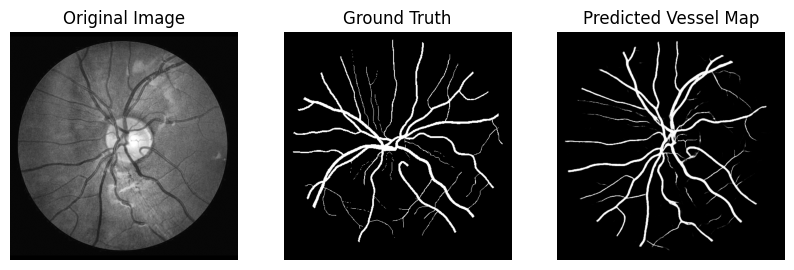

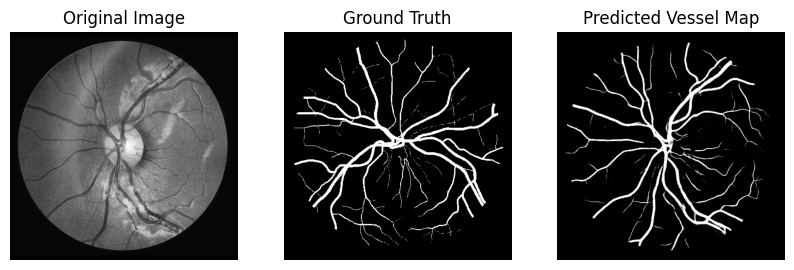

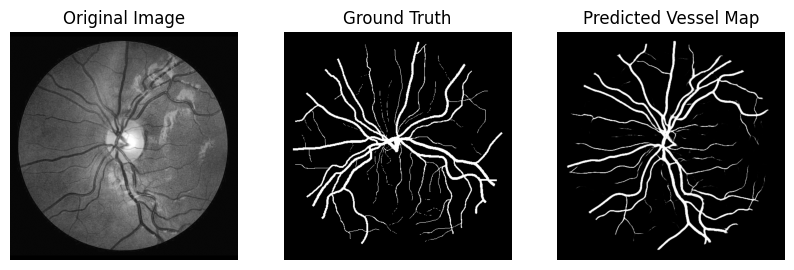

In [41]:
# ============================================================
# STEP 6 — Visualization: Input vs Ground Truth vs Prediction
# ============================================================

import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_predictions(model, loader, n=3):
    model.eval()
    imgs, masks, preds = [], [], []
    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            mask = mask.permute(0,3,1,2)
            output = torch.sigmoid(model(img))
            imgs.append(img.cpu().numpy())
            masks.append(mask.cpu().numpy())
            preds.append(output.cpu().numpy())
            if len(imgs) >= n:
                break

    for i in range(n):
        image = np.squeeze(imgs[i][0])         # (128×128)
        gt     = np.squeeze(masks[i][0])
        pred   = np.squeeze(preds[i][0])

        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(image, cmap='gray')
        plt.title("Original Image"); plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(gt, cmap='gray')
        plt.title("Ground Truth"); plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred, cmap='gray')
        plt.title("Predicted Vessel Map"); plt.axis('off')

        plt.show()

# 🔹 Visualize on test samples
visualize_predictions(model, test_loader, n=3)


In [32]:
!pip install segmentation-models-pytorch timm hf_xet



In [13]:
import gc, torch

# Delete any existing model objects
try:
    del model
except:
    pass

# Force garbage collection
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

print("✅ GPU memory cleared — safe to start new model training!")


✅ GPU memory cleared — safe to start new model training!


In [20]:
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

def dice_loss_from_logits(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * target).sum() + eps
    den = probs.sum() + target.sum() + eps
    return 1 - (num / den)

def focal_dice_loss(logits, target, alpha=0.25, gamma=2.0):
    bce = F.binary_cross_entropy_with_logits(logits, target, reduction='none')
    pt = torch.exp(-bce)
    focal = alpha * (1 - pt) ** gamma * bce
    return 0.5 * focal.mean() + 0.5 * dice_loss_from_logits(logits, target)
def replace_bn_with_gn(model, num_groups=8):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.BatchNorm2d):
            setattr(model, name,
                    torch.nn.GroupNorm(num_groups, module.num_features))
        else:
            replace_bn_with_gn(module, num_groups)
def make_model(name="deeplabv3plus", encoder="resnet34"):
    if name == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
    elif name == "unetpp":
        model = smp.UnetPlusPlus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
    else:
        raise ValueError("Unknown model")

    # 🔥 REQUIRED for CPU / small batch training
    replace_bn_with_gn(model)

    model.to(DEVICE)
    return model
def train_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0

    for imgs, masks in tqdm(loader, leave=False):
        imgs = imgs.to(DEVICE)
        masks = masks.to(DEVICE)  # [B,1,H,W]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = focal_dice_loss(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)
def evaluate_epoch(model, loader):
    model.eval()
    total_dice, total_acc = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, leave=False):
            imgs = imgs.to(DEVICE)
            masks = masks.to(DEVICE)

            outputs = torch.sigmoid(model(imgs))
            preds = (outputs > 0.5).float()

            dice = 1 - dice_loss_from_logits(outputs, masks)
            acc = (preds == masks).float().mean()

            total_dice += dice.item()
            total_acc += acc.item()

    return total_dice / len(loader), total_acc / len(loader)
EPOCHS = 50
results = {}

for model_name in ["deeplabv3plus", "unetpp"]:
    print(f"\n🚀 Training {model_name.upper()} ...")

    model = make_model(model_name)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    best_dice = 0.0

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_epoch(model, train_loader, optimizer)
        val_dice, val_acc = evaluate_epoch(model, val_loader)
        scheduler.step()

        print(
            f"Epoch {epoch:03d} | "
            f"Loss {train_loss:.4f} | "
            f"Val Dice {val_dice:.4f} | "
            f"Val Acc {val_acc:.4f}"
        )

        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), f"{model_name}_best.pth")

    results[model_name] = {"BestDice": round(best_dice, 4)}

print("\n✅ Training completed successfully!")
print(results)


Using device: cpu

🚀 Training DEEPLABV3PLUS ...


Epoch 001 | Loss 0.3336 | Val Dice 0.1409 | Val Acc 0.9445


Epoch 002 | Loss 0.2382 | Val Dice 0.1446 | Val Acc 0.9466


Epoch 003 | Loss 0.2263 | Val Dice 0.1442 | Val Acc 0.9497


Epoch 004 | Loss 0.2215 | Val Dice 0.1477 | Val Acc 0.9421


Epoch 005 | Loss 0.2195 | Val Dice 0.1441 | Val Acc 0.9533


Epoch 006 | Loss 0.2153 | Val Dice 0.1463 | Val Acc 0.9506


Epoch 007 | Loss 0.2125 | Val Dice 0.1459 | Val Acc 0.9528


Epoch 008 | Loss 0.2110 | Val Dice 0.1469 | Val Acc 0.9515


Epoch 009 | Loss 0.2086 | Val Dice 0.1479 | Val Acc 0.9499


Epoch 010 | Loss 0.2060 | Val Dice 0.1464 | Val Acc 0.9563


Epoch 011 | Loss 0.2004 | Val Dice 0.1486 | Val Acc 0.9493


Epoch 012 | Loss 0.2010 | Val Dice 0.1454 | Val Acc 0.9594


Epoch 013 | Loss 0.1966 | Val Dice 0.1461 | Val Acc 0.9591


Epoch 014 | Loss 0.1942 | Val Dice 0.1459 | Val Acc 0.9593


Epoch 015 | Loss 0.1917 | Val Dice 0.1467 | Val Acc 0.9594


Epoch 016 | Loss 0.1933 | Val Dice 0.1468 | Val Acc 0.9580


Epoch 017 | Loss 0.1936 | Val Dice 0.1463 | Val Acc 0.9603


Epoch 018 | Loss 0.1906 | Val Dice 0.1477 | Val Acc 0.9581


Epoch 019 | Loss 0.1898 | Val Dice 0.1478 | Val Acc 0.9591


Epoch 020 | Loss 0.1921 | Val Dice 0.1482 | Val Acc 0.9589


Epoch 021 | Loss 0.1895 | Val Dice 0.1469 | Val Acc 0.9607


Epoch 022 | Loss 0.1895 | Val Dice 0.1465 | Val Acc 0.9612


Epoch 023 | Loss 0.1864 | Val Dice 0.1468 | Val Acc 0.9609


Epoch 024 | Loss 0.1854 | Val Dice 0.1480 | Val Acc 0.9588


Epoch 025 | Loss 0.1818 | Val Dice 0.1483 | Val Acc 0.9584


Epoch 026 | Loss 0.1868 | Val Dice 0.1484 | Val Acc 0.9585


Epoch 027 | Loss 0.1869 | Val Dice 0.1484 | Val Acc 0.9586


Epoch 028 | Loss 0.1862 | Val Dice 0.1490 | Val Acc 0.9583


Epoch 029 | Loss 0.1847 | Val Dice 0.1468 | Val Acc 0.9618


Epoch 030 | Loss 0.1871 | Val Dice 0.1466 | Val Acc 0.9624


Epoch 031 | Loss 0.1867 | Val Dice 0.1483 | Val Acc 0.9601


Epoch 032 | Loss 0.1843 | Val Dice 0.1473 | Val Acc 0.9609


Epoch 033 | Loss 0.1851 | Val Dice 0.1484 | Val Acc 0.9602


Epoch 034 | Loss 0.1848 | Val Dice 0.1474 | Val Acc 0.9617


Epoch 035 | Loss 0.1857 | Val Dice 0.1474 | Val Acc 0.9618


Epoch 036 | Loss 0.1844 | Val Dice 0.1484 | Val Acc 0.9604


Epoch 037 | Loss 0.1851 | Val Dice 0.1486 | Val Acc 0.9600


Epoch 038 | Loss 0.1822 | Val Dice 0.1475 | Val Acc 0.9619


Epoch 039 | Loss 0.1823 | Val Dice 0.1481 | Val Acc 0.9611


Epoch 040 | Loss 0.1818 | Val Dice 0.1474 | Val Acc 0.9621


Epoch 041 | Loss 0.1823 | Val Dice 0.1482 | Val Acc 0.9612


Epoch 042 | Loss 0.1843 | Val Dice 0.1479 | Val Acc 0.9616


Epoch 043 | Loss 0.1835 | Val Dice 0.1477 | Val Acc 0.9618


Epoch 044 | Loss 0.1849 | Val Dice 0.1473 | Val Acc 0.9622


Epoch 045 | Loss 0.1816 | Val Dice 0.1477 | Val Acc 0.9618


Epoch 046 | Loss 0.1819 | Val Dice 0.1480 | Val Acc 0.9614


Epoch 047 | Loss 0.1807 | Val Dice 0.1477 | Val Acc 0.9619


Epoch 048 | Loss 0.1829 | Val Dice 0.1479 | Val Acc 0.9616


Epoch 049 | Loss 0.1829 | Val Dice 0.1479 | Val Acc 0.9617


Epoch 050 | Loss 0.1809 | Val Dice 0.1479 | Val Acc 0.9617

🚀 Training UNETPP ...


Epoch 001 | Loss 0.3341 | Val Dice 0.1436 | Val Acc 0.9565


Epoch 002 | Loss 0.2173 | Val Dice 0.1409 | Val Acc 0.9631


Epoch 003 | Loss 0.1853 | Val Dice 0.1474 | Val Acc 0.9635


Epoch 004 | Loss 0.1742 | Val Dice 0.1475 | Val Acc 0.9671


Epoch 005 | Loss 0.1682 | Val Dice 0.1460 | Val Acc 0.9678


Epoch 006 | Loss 0.1693 | Val Dice 0.1481 | Val Acc 0.9670


Epoch 007 | Loss 0.1685 | Val Dice 0.1485 | Val Acc 0.9688


Epoch 008 | Loss 0.1638 | Val Dice 0.1486 | Val Acc 0.9686


Epoch 009 | Loss 0.1594 | Val Dice 0.1503 | Val Acc 0.9675


Epoch 010 | Loss 0.1593 | Val Dice 0.1488 | Val Acc 0.9699


Epoch 011 | Loss 0.1553 | Val Dice 0.1503 | Val Acc 0.9698


Epoch 012 | Loss 0.1550 | Val Dice 0.1502 | Val Acc 0.9686


Epoch 013 | Loss 0.1542 | Val Dice 0.1494 | Val Acc 0.9715


Epoch 014 | Loss 0.1542 | Val Dice 0.1509 | Val Acc 0.9692


Epoch 015 | Loss 0.1537 | Val Dice 0.1521 | Val Acc 0.9682


Epoch 016 | Loss 0.1524 | Val Dice 0.1505 | Val Acc 0.9715


Epoch 017 | Loss 0.1480 | Val Dice 0.1496 | Val Acc 0.9701


Epoch 018 | Loss 0.1504 | Val Dice 0.1492 | Val Acc 0.9718


Epoch 019 | Loss 0.1511 | Val Dice 0.1495 | Val Acc 0.9719


Epoch 020 | Loss 0.1471 | Val Dice 0.1517 | Val Acc 0.9702


Epoch 021 | Loss 0.1503 | Val Dice 0.1514 | Val Acc 0.9709


Epoch 022 | Loss 0.1466 | Val Dice 0.1513 | Val Acc 0.9715


Epoch 023 | Loss 0.1479 | Val Dice 0.1515 | Val Acc 0.9706


Epoch 024 | Loss 0.1439 | Val Dice 0.1512 | Val Acc 0.9713


Epoch 025 | Loss 0.1494 | Val Dice 0.1509 | Val Acc 0.9703


Epoch 026 | Loss 0.1469 | Val Dice 0.1516 | Val Acc 0.9715


Epoch 027 | Loss 0.1465 | Val Dice 0.1520 | Val Acc 0.9704


Epoch 028 | Loss 0.1453 | Val Dice 0.1517 | Val Acc 0.9719


Epoch 029 | Loss 0.1457 | Val Dice 0.1517 | Val Acc 0.9709


Epoch 030 | Loss 0.1442 | Val Dice 0.1514 | Val Acc 0.9722


Epoch 031 | Loss 0.1457 | Val Dice 0.1504 | Val Acc 0.9728


Epoch 032 | Loss 0.1432 | Val Dice 0.1513 | Val Acc 0.9724


Epoch 033 | Loss 0.1431 | Val Dice 0.1511 | Val Acc 0.9730


Epoch 034 | Loss 0.1440 | Val Dice 0.1514 | Val Acc 0.9727


Epoch 035 | Loss 0.1455 | Val Dice 0.1521 | Val Acc 0.9715


Epoch 036 | Loss 0.1420 | Val Dice 0.1517 | Val Acc 0.9726


Epoch 037 | Loss 0.1440 | Val Dice 0.1520 | Val Acc 0.9723


Epoch 038 | Loss 0.1424 | Val Dice 0.1514 | Val Acc 0.9729


Epoch 039 | Loss 0.1428 | Val Dice 0.1511 | Val Acc 0.9731


Epoch 040 | Loss 0.1385 | Val Dice 0.1514 | Val Acc 0.9728


Epoch 041 | Loss 0.1404 | Val Dice 0.1517 | Val Acc 0.9726


Epoch 042 | Loss 0.1425 | Val Dice 0.1514 | Val Acc 0.9728


Epoch 043 | Loss 0.1408 | Val Dice 0.1515 | Val Acc 0.9731


Epoch 044 | Loss 0.1391 | Val Dice 0.1514 | Val Acc 0.9731


Epoch 045 | Loss 0.1405 | Val Dice 0.1516 | Val Acc 0.9729


Epoch 046 | Loss 0.1394 | Val Dice 0.1517 | Val Acc 0.9728


Epoch 047 | Loss 0.1405 | Val Dice 0.1517 | Val Acc 0.9728


Epoch 048 | Loss 0.1391 | Val Dice 0.1517 | Val Acc 0.9728


Epoch 049 | Loss 0.1409 | Val Dice 0.1517 | Val Acc 0.9727


Epoch 050 | Loss 0.1410 | Val Dice 0.1517 | Val Acc 0.9727

✅ Training completed successfully!
{'deeplabv3plus': {'BestDice': 0.149}, 'unetpp': {'BestDice': 0.1521}}


In [9]:
import segmentation_models_pytorch as smp
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def make_model(name="deeplabv3plus", encoder="resnet34"):
    if name == "deeplabv3plus":
        model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
    elif name == "unetpp":
        model = smp.UnetPlusPlus(
            encoder_name=encoder,
            encoder_weights="imagenet",
            in_channels=1,
            classes=1
        )
    else:
        raise ValueError("Unknown model name")

    # 🔒 Freeze BatchNorm (important for CPU / small batch eval)
    for m in model.modules():
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()

    return model.to(DEVICE)


In [47]:
# STAGE-2 STEP:1 Probability Map Generation

import os
import torch
import cv2
import numpy as np
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load trained MSF-Net weights
msf_net.load_state_dict(torch.load("msfnet_best.pth", map_location=DEVICE))
msf_net.eval()
msf_net.to(DEVICE)

# Dataset paths
BASE_DIR = "Retina Vessel Segmentation"
IMAGE_DIRS = [
    os.path.join(BASE_DIR, "Training", "Images"),
    os.path.join(BASE_DIR, "Test", "Images")
]

# Output folder for Stage-2
SAVE_DIR = os.path.join(BASE_DIR, "stage2_masks")
os.makedirs(SAVE_DIR, exist_ok=True)

# Collect all images
all_images = []
for d in IMAGE_DIRS:
    for f in os.listdir(d):
        if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif")):
            all_images.append(os.path.join(d, f))

print("Total images for mask generation:", len(all_images))

# Generate vessel masks
with torch.no_grad():
    for img_path in tqdm(all_images):
        img = preprocess_image(img_path)
        img = torch.tensor(img).permute(2,0,1).unsqueeze(0).to(DEVICE)

        prob_map = torch.sigmoid(msf_net(img))[0,0].cpu().numpy()

        # SAVE PROBABILITY MAP (NOT BINARY)
        mask = (prob_map * 255).astype(np.uint8)

        name = os.path.basename(img_path)
        cv2.imwrite(os.path.join(SAVE_DIR, name), mask)


print("Stage-2 Step-1 COMPLETE: Vessel masks generated")


Total images for mask generation: 141


100%|██████████| 141/141 [01:35<00:00,  1.47it/s]

Stage-2 Step-1 COMPLETE: Vessel masks generated


In [ ]:
# ============================================================
# STAGE-2 STEP-2 — Vessel Refinement & Final Mask Generation
# ============================================================

import os
import cv2
import numpy as np
from tqdm import tqdm

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
BASE_DIR = "Retina Vessel Segmentation"
INPUT_DIR = os.path.join(BASE_DIR, "stage2_masks")          # MSF-Net output
OUTPUT_DIR = os.path.join(BASE_DIR, "final_vessel_masks")  # Final output
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Post-processing function
# ------------------------------------------------------------
def refine_vessels(prob_img):
    """
    prob_img: uint8 image (0–255) from MSF-Net
    returns: clean binary vessel mask
    """

    # 1️ Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(prob_img)

    # 2️ Noise suppression
    blurred = cv2.GaussianBlur(enhanced, (5,5), 0)

    # 3️ Adaptive threshold (better than fixed threshold)
    binary = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        15,
        -5
    )

    # 4️⃣ Morphological cleanup
    kernel = np.ones((3,3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel)

    return clean

# ------------------------------------------------------------
# Run Stage-2 Step-2
# ------------------------------------------------------------
files = [f for f in os.listdir(INPUT_DIR) if f.endswith((".png",".jpg",".tif"))]

print("Processing images:", len(files))

for fname in tqdm(files):
    path = os.path.join(INPUT_DIR, fname)
    prob_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    final_mask = refine_vessels(prob_img)

    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), final_mask)

print(" Stage-2 Step-2 COMPLETE: Final vessel masks generated")


Processing images: 141


100%|██████████| 141/141 [00:00<00:00, 365.45it/s]

✅ Stage-2 Step-2 COMPLETE: Final vessel masks generated


In [ ]:
# ============================================================
# STAGE-2 — STEP-3 FINAL EVALUATION ON FINAL_VESSEL_MASKS
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, confusion_matrix

# -----------------------------
# PATHS (EDIT ONLY IF NEEDED)
# -----------------------------
BASE_DIR = "Retina Vessel Segmentation"

PRED_DIR = os.path.join(BASE_DIR, "final_vessel_masks")
GT_DIR   = os.path.join(BASE_DIR, "Test", "Masks")   # Ground Truth

# -----------------------------
# METRICS
# -----------------------------
def dice_score(pred, gt):
    pred = pred.astype(bool)
    gt   = gt.astype(bool)
    inter = np.logical_and(pred, gt).sum()
    return (2 * inter) / (pred.sum() + gt.sum() + 1e-6)

# -----------------------------
# DATASET FILTER
# -----------------------------
def filter_dataset(files, keyword):
    return [f for f in files if keyword.lower() in f.lower()]

# -----------------------------
# LOAD FILES
# -----------------------------
pred_files = sorted(os.listdir(PRED_DIR))
gt_files   = sorted(os.listdir(GT_DIR))

datasets = {
    "DRIVE": "drive",
    "STARE": "stare",
    "CHASE_DB1": "chase",
    "HRF": "hrf",
    "RITE": "rite",
    "LES_AV": "les"
}

results = []

# -----------------------------
# EVALUATION LOOP
# -----------------------------
for dname, key in datasets.items():

    pred_list = filter_dataset(pred_files, key)
    gt_list   = filter_dataset(gt_files, key)

    if len(pred_list) == 0:
        continue

    dice_vals, all_pred, all_gt = [], [], []

    for pf, gf in tqdm(zip(pred_list, gt_list), total=len(pred_list), desc=f"Evaluating {dname}"):

        pred = cv2.imread(os.path.join(PRED_DIR, pf), cv2.IMREAD_GRAYSCALE)
        gt   = cv2.imread(os.path.join(GT_DIR, gf), cv2.IMREAD_GRAYSCALE)

        # 🔧 FIX SIZE MISMATCH
        if pred.shape != gt.shape:
            gt = cv2.resize(gt, (pred.shape[1], pred.shape[0]), interpolation=cv2.INTER_NEAREST)

        pred_bin = (pred > 127).astype(np.uint8)
        gt_bin   = (gt > 127).astype(np.uint8)

        dice_vals.append(dice_score(pred_bin, gt_bin))
        all_pred.extend(pred_bin.flatten())
        all_gt.extend(gt_bin.flatten())

    # Metrics
    auc = roc_auc_score(all_gt, all_pred)
    tn, fp, fn, tp = confusion_matrix(all_gt, all_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)
    se  = tp / (tp + fn + 1e-6)
    sp  = tn / (tn + fp + 1e-6)

    results.append([
        dname,
        auc * 100,
        np.mean(dice_vals) * 100,
        acc * 100,
        se * 100,
        sp * 100
    ])

# -----------------------------
# DISPLAY RESULTS
# -----------------------------
df = pd.DataFrame(results, columns=[
    "Dataset",
    "AUC (%)",
    "Dice / F1 (%)",
    "Accuracy (%)",
    "Sensitivity (%)",
    "Specificity (%)"
]).round(2)

print("\n STAGE-2 FINAL VESSEL MASK EVALUATION")
print(df.to_string(index=False))


Evaluating LES_AV:  25%|██▌       | 2/8 [00:00<00:00, 85.57it/s]



✅ STAGE-2 FINAL VESSEL MASK EVALUATION
  Dataset  AUC (%)  Dice / F1 (%)  Accuracy (%)  Sensitivity (%)  Specificity (%)
    DRIVE    53.29          14.56         84.58            15.22            91.35
CHASE_DB1    70.80          44.65         91.08            46.87            94.74
      HRF    51.48          10.23         86.16            10.68            92.28
     RITE    53.40          14.61         84.47            16.18            90.62
   LES_AV    53.36          13.73         86.02            15.04            91.69
